# Common Misconceptions and Confidence Intervals

## Some Definitions 

* $H_0$ : null hypothesis: The hypotheis that the effect we are testing for is null

* $H_A$ : alternative hypothesis : Not $H_0$, so there is some signal

* $T$ : The random variable that takes value "significant" or "not significant"

* $T_S$ : Value of T when test is significant (eg $T = T_S$)

* $T_N$ : Value of T when test is not significant (eg $T = T_N$)

* $\alpha$ : false positive rate - probability to reject $H_0$ when $H_0$ is true (therefore $H_A$ is false)

* $\beta$ : false negative rate - probability to accept $H_0$ when $H_A$ is true (i.e. $H_0$ is false)


power = $1-\beta$ 

where $\beta$ is the risk of *false negative*

So, to compute power, *we need to know what is the risk of false negative*, ie, the risk to not show a significant effect while we have some signal (null is false).

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy.stats as sst

In [2]:
import scipy.stats as sst
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division
from IPython.display import Image as Image

In [3]:
from matplotlib.patches import Polygon

def stat_power(n=16, mu=1., sigma=1., alpha=0.05, plot=False, xlen=500):
    """
    This function computes the statistical power of an analysis assuming a normal
    distribution of the data with a one sample t-test
    
    Parameters:
    -----------
    n: int,
        The number of sample in the experiment
    mu: float
        The mean of the alternative
    sigma: float
        The standard deviation of the alternative
    plot: bool
        Plot something
    alpha: float
        The risk of error (type I)
    xlen: int
        Number of points for the display
    
    Returns:
    --------
    float
        The statistical power for this number of sample, mu, sigma, alpha
    """
    df = n-1
    theta = np.sqrt(n)*mu/sigma
    t_alph_null = sst.t.isf(alpha, df)
    ncrv = sst.nct(df, theta)
    spow = 1 - ncrv.cdf(t_alph_null)
    
    if plot:
        # define the domain of the plot
        norv = sst.norm(0, 1.)
        bornesnc = ncrv.isf([0.001, .999])
        bornesn = norv.isf([0.001, .999])
        # because the nc t will have higher max borne, and the H0 normal will be on the left
        x = np.linspace(np.min(bornesn), np.max(bornesnc), xlen)
        t_line = np.zeros_like(x)
        # define the line 
        x_t_line = np.argmin((x-t_alph_null)**2)
        y_t_line = np.max(np.hstack((ncrv.pdf(x), norv.pdf(x))))
        t_line[x_t_line] = y_t_line

        fig, ax = plt.subplots()
        plt.plot(x, ncrv.pdf(x), 'g', x, norv.pdf(x), 'b', x, t_line, 'r')
        
        # Make the shaded region
        # http://matplotlib.org/xkcd/examples/showcase/integral_demo.html
        a = x[x_t_line]; b =  np.max(bornesnc);
        ix = np.linspace(a,b)
        iy = ncrv.pdf(ix)
        verts = [(a, 0)] + list(zip(ix, iy)) + [(b, 0)]
        poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
        ax.add_patch(poly)
        
        ax.set_xlabel("t-value - H1 centred on " + r"$\theta $" + " = %4.2f;  " %theta 
                      + r"$\mu$" + " = %4.2f" %mu); 
        ax.set_ylabel("Probability(t)");
        ax.set_title('H0 and H1 sampling densities ' 
                     + r'$\beta$' + '= %3.2f' %spow + ' n = %d' %n)
        plt.show()

    return spow


## Karl Friston 16 subjects magic number - cf Tal Yarkoni's answer

* Rule number four: the under-sampled study
* Rule number five: the over-sampled study
* Rule number eight: exploit superstitious thinking about voodoo correlations

### KF arguments can be summarized by:

1.  The null is always false: no effects are ever truly zero. Collect enough data and you will always end up rejecting the null.

2.  Large effects are more important than small ones. Very small effects are ‘trivial’.

3.  Very large samples will invariably end up identifying many small uninteresting effects. We should sample few subjects to detect only the big effects.


In [4]:
# power of KF analysis : d=1, 
n = 16; mu = .5; sigma = 1.; alpha = 0.05
stat_power(n, mu, sigma, alpha=alpha, plot=False)

0.60403286833160075

### 1. A less favorable case

#### We are doing many test and have to decrease $\alpha$ - 

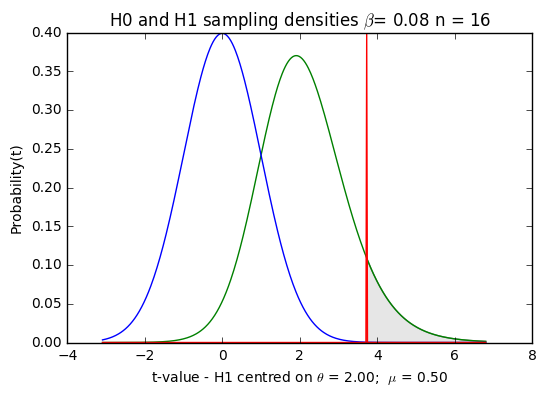

0.082272442280301838

In [5]:
# analysis in a slightly less favorable case 
n = 16; mu = .5; sigma = 1.; alpha = 0.001
stat_power(n, mu, sigma, plot=True, alpha = alpha)

### In neuroimaging non corrected p-value are small, let's plot n as a function of alpha :

In [6]:
def n_power(pw=.8, mu=1., sigma=1., alpha=0.05):
    """
    compute the number of subjects needed to get pw given 
    mu, sigma and alpha
    """
    norv = sst.norm(0,1.)
    ta = norv.ppf(1 - alpha)
    tb = norv.ppf(1 - pw)
    n = (sigma*(ta - tb)/mu)**2
    return n


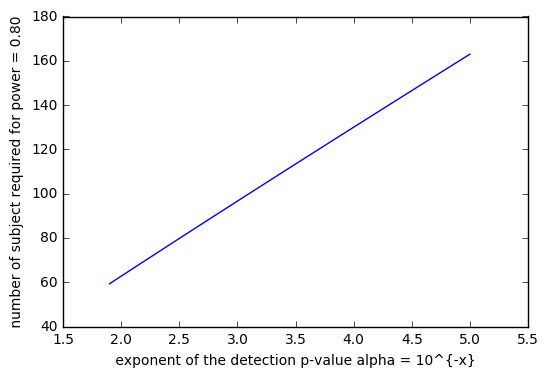

In [7]:
mu = .4; sigma = 1.; pw = .8

lnalph = np.arange(1.9,5.1,.1)
nsub = [n_power(pw, mu, sigma, alpha=10**(-a)) for a in lnalph]
plt.plot(lnalph, nsub)
plt.xlabel(' exponent of the detection p-value alpha = 10^{-x} ')
plt.ylabel(' number of subject required for power = %3.2f ' % pw)
#xscale('log')

### 2. The uncertainty of small n results is very high. Confidence interval are just above zero.

In [8]:
def confidence_intervals(Nexp, **prmtrs):
    """
    Nexp: the number of experiments done
    prmtrs: a dictionary with our parameters, 
        example: prmtrs = {'n':16, 'mu':.3, 'sigma': 1., 'alpha': 0.05}
        
    returns arrays of size Nexp with:
    effect: the estimated effect
    detect: an array of 0 or 1, 1 when the effect is detected at alpha
    lCI: lower bound of confidence interval
    uCI: upper bound of confidence interval
    """
    # unpack parameters:
    n = prmtrs['n']
    mu = prmtrs['mu']; 
    alpha = prmtrs['alpha']; 
    sigma = prmtrs['sigma']
    df = n-1
    theta = mu*np.sqrt(n)/sigma
    
    # initialize arrays
    t = np.zeros((Nexp,))
    effect = np.zeros((Nexp,))
    lCI = np.zeros((Nexp,))
    uCI = np.zeros((Nexp,))

    # compute random variables and thresholds
    norv = sst.norm(0., sigma)
    strv = sst.t(df)
    # get the 0.05 t value *under the null* to construct confidence interval
    t_05 = strv.isf(0.05)
    # get the alpha level t value *under the null* to detect 
    t_alph = strv.isf(alpha)
    

    for experim in range(Nexp):
        # get n sample
        sample = norv.rvs(size=(n,)) + mu
        # effect and normalized effect size
        effect[experim] = sample.mean()
        std_error_data = np.std(sample, ddof=1) 
        std_error_mean = std_error_data/np.sqrt(n) # np.std takes ddof as 
                                                    # the df of freedom lost! here: 1.
        t[experim] = effect[experim]/std_error_mean
        # confidence interval :
        CI_05 = t_05*std_error_mean
        lCI[experim] = effect[experim] - CI_05 # t_alph # 
        uCI[experim] = effect[experim] + CI_05 # t_alph # 

    # number of detection:
    detect = t>t_alph
#    print 'number of detections:', xd.shape

    return (effect, detect, lCI, uCI)

In [13]:
#---------------------- parameters ------------------#
prmtrs = {'n':30, 'mu':.25, 'sigma': 1., 'alpha': 0.05}
theta = prmtrs['mu']*np.sqrt(prmtrs['n'])/prmtrs['sigma']
Pw = stat_power(prmtrs['n'], prmtrs['mu'], alpha=prmtrs['alpha'])
print('mean t value should be around %3.2f \n' %theta)

#--------------  simulate Nexp experiments ---------#
Nexp = 1000
effect, detect, lCI, uCI = confidence_intervals(Nexp, **prmtrs)

print("Compare power {:.3} and rate of detection {:.3} ".format(Pw, detect.sum()/Nexp))
print("Mean effect {:.3f} compared to average detected effect {:3f}".format(
                    effect.mean(), effect[detect].mean()))
print("Lower bound > mu: {} lCI > mu {:3f} detected: {} over {}".format(
                    (lCI[detect]>mu).sum(), (lCI[detect]>mu).sum()/detect.sum(), detect.sum(), Nexp ))



mean t value should be around 1.37 

Compare power 0.379 and rate of detection 0.329 
Mean effect 0.233 compared to average detected effect 0.427848
Lower bound > mu: 8 lCI > mu 0.024316 detected: 329 over 1000


In [14]:
lCI[detect].mean(), (lCI[detect]>mu).sum(), (uCI[detect]<mu).sum(), lCI[detect].shape, lCI.mean()


(0.12709466392234547, 8, 1, (329,), -0.076823232701366012)

lCI > mu :  0.0243, compare with 0.05 
1000


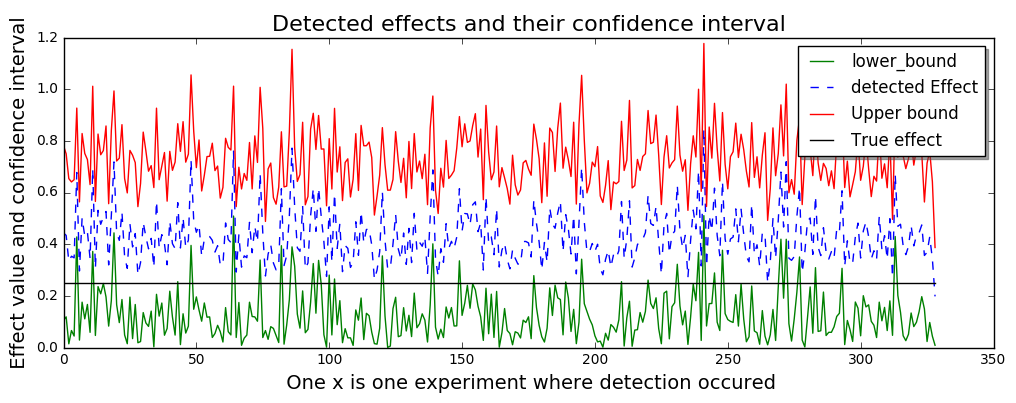

In [15]:
#--------------  plot ------------------------------#
x = np.arange(Nexp)
xd = np.arange(detect.sum())
mu_line = np.ones((Nexp,))*prmtrs['mu']

# print the number of lower confidence interval values that are above the true mean:
# this should be about the risk of error/2
print("lCI > mu :  {:.3}, compare with {:.3} ".format( 
                (lCI > mu).sum() / (1.*detect.sum()),  prmtrs['alpha'])) #
print(Nexp)
# there should be none of these:
# print "(lCI < 0 ", (lCI[detect] < 0).sum() / detect.sum()

f = plt.figure(1).set_size_inches(12,4)
lines = plt.plot(xd, lCI[detect], 'g-', 
                 xd, effect[detect], 'b--',
                 xd, uCI[detect], 'r-',
                 xd, mu_line[detect], 'k');
plt.legend( lines, ('lower_bound','detected Effect', 'Upper bound', 'True effect'), 
                   loc='upper right', shadow=True)
plt.xlabel(" One x is one experiment where detection occured", fontdict={'size':14})
plt.ylabel(" Effect value and confidence interval ", fontdict={'size':14})
plt.title("Detected effects and their confidence interval", fontdict={'size':16});

### 3. Our prior is that effect sizes are small

* big effects have been found  : see Meyer et al (2001)
* big effect sizes are less likely than small ones :  the prior of big effects is low
* large sample studies report lower effects - as well as intra subjects

Example of Desmond and Glover 2002: using a threshold of 0.01, working memory task, 12 subject:


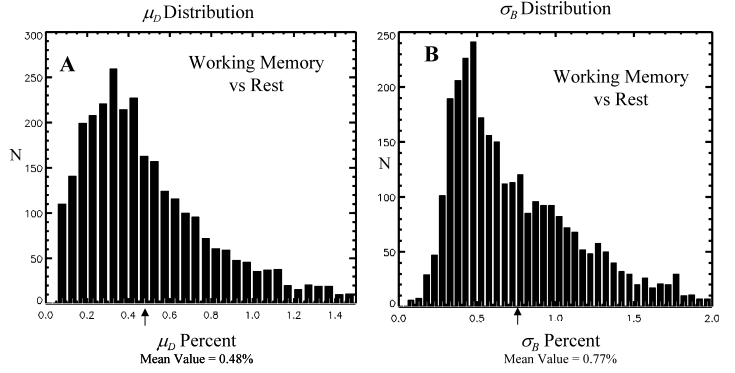

In [12]:
Image('./figures/Desmond_Glover_effectsize.png')

## "Protected inference" : 

### Protect against small effect if you want to by redefining the null (i.e., effect is within [-.1 .1])

## References

Katherine S. Button, John P. A. Ioannidis, Claire Mokrysz1, Brian A. Nosek4,
Jonathan Flint5, Emma S. J. Robinson6 and Marcus R. Munafò. Power failure: why small sample
size undermines the reliability of neuroscience.

T. Yarkoni, 2012 [citation needed]» Blog Archive » Sixteen is not magic: Comment on Friston (2012)

Desmond and Glover, Estimating sample size in functional MRI (fMRI) neuroimaging
studies: Statistical power analyses, Journal of Neuroscience Methods 118 (2002) 115/128.

K. Friston, 2012, Neuroimage. Ten ironic rules for non-statistical reviewers

Joseph P. Simmons, Leif D. Nelson and Uri Simonsohn. False-Positive Psychology: Undisclosed Flexibility in Data Collection and Analysis Allows Presenting Anything as Significant. Psychological Science. 2011.

C. Glenn Begley	 & Lee M. Ellis. Drug development: Raise standards for preclinical cancer research. Nature, 2012.

M Brandon Westover, Kenneth D Westover, Matt T Bianchi, 2011, BMC Medecine, Significance testing as perverse probabilistic reasoning.

Johnson, V.E. (2013). Revised standards for statistical evidence. Proceedings of the National Academy of Sciences 110, 19313–19317.

Halsey, L.G., Curran-Everett, D., Vowler, S.L., and Drummond, G.B. (2015). The fickle P value generates irreproducible results. Nature Methods 12, 179–185.

Eklund, A., Andersson, M., Josephson, C., Johannesson, M., and Knutsson, H. (2012). Does parametric fMRI analysis with SPM yield valid results?—An empirical study of 1484 rest datasets. NeuroImage 61, 565–578.


Carp, J. The secret lives of experiments: methods reporting in the fMRI literature. Neuroimage 63,
289–300 (2012).

    This article reviews methods reporting and methodological choices across 241 recent fMRI    studies and shows that there were nearly as many unique analytical pipelines as there were studies. In addition, many studies were underpowered to detect plausible effects.

Sander Heinsalu:

    "Publication bias is a problem in all fields of research. The results of a paper should actually receive zero weight in the evaluation of its quality, otherwise there is the motivation to cherry-pick the data that give the most impressive result. The measure of quality should be the way the results were obtained – size of sample, experimental procedure, endpoints used. Ideally the reviewers of a paper should not see its results at all, only the description of the experiment."


### Related blog posts:

http://daniellakens.blogspot.ca/2015/11/the-relation-between-p-values-and.html

